# Informations importantes concernant le rapport

Nous avons fait le choix de retirer les consignes et autres commentaires d'origine dans le document, afin d'avoir un rapport plus épuré.

Le dernier bloc de code est un condensé des étapes nécessaires à la prédiction, sans compter la génération du model et le fit.
Ce bloc était destiné à faire des prédictions sur des models déjà sauvegardés à l'avance, mais colab ne fait que des sauvegardes temporaires donc à moins de partager un model externe, le dernier bloc ne fonctionnera pas sans avoir exécuté tout les blocs précédents.

Nous avons également deux représentations graphiques qui nous ont permises d'observer l'évolution de notre model, et de visualiser l'overfitting.

- `data` contiendra les données sur lesquelles faire l'apprentissage (ces données contiennent la valeur qu'il faut prévoir pour entrainer le réseau)
- `data_to_evaluate` contiendra les données sur lesquelles faire les prédictions.

In [ ]:
# Import du fichier d'exemples

def get_raw_data_go(file):
    ''' Returns the set of samples from the local file or download it if it does not exists'''
    import gzip, os.path
    import json

    if not os.path.isfile(file):
        print("File", file, "not found, I am downloading it...", end="")
        import urllib.request 
        urllib.request.urlretrieve ("https://www.labri.fr/perso/lsimon/IA-M1/" + file, file)
        print(" Done")

    with gzip.open(file) as fz:
        data = json.loads(fz.read().decode("utf-8"))
    return data

data = get_raw_data_go("samples-9x9.json.gz")
data_to_evaluate = get_raw_data_go("positions-to-evaluate-9x9.json.gz")

print("We have", len(data),"examples with the scores to train, ...")
print("We have", len(data_to_evaluate),"examples to score (but for which we don't know the real values)")

We have 41563 examples with the scores to train, ...
We have 1000 examples to score (but for which we don't know the real values)


# First steps: transform all the data into numpy arrays to feed your neural network

In [ ]:
import numpy as np

def name_to_coord(s):
    assert s != "PASS"
    indexLetters = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'J':8}

    col = indexLetters[s[0]]
    lin = int(s[1:]) - 1
    return col, lin

def json_to_numpy(sample):
  to_return = np.zeros((9,9,2))
  indices = ["black_stones", "white_stones"]
  for plane, name in enumerate(indices):
    for coord_name in sample[name]:
      x, y = name_to_coord(coord_name)
      to_return[x,y,plane] = 1
  return to_return

# Second steps: build your neural network and train it

In [ ]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D,  MaxPooling2D, BatchNormalization
import tensorflow.keras.optimizers as optimizers
import tensorflow as tf

model = Sequential()

model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(9,9,2), padding ='same'))
model.add(Dropout(rate=0.25))
model.add(Conv2D(8, kernel_size=(3,3), activation='relu', padding ='same'))
model.add(Dropout(rate=0.25))
model.add(Conv2D(4, kernel_size=(3,3), activation='sigmoid', padding ='same'))
model.add(Flatten())
model.add(Dense(9*9, activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 9, 9, 16)          304       
_________________________________________________________________
dropout_6 (Dropout)          (None, 9, 9, 16)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 9, 9, 8)           1160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 9, 9, 8)           0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 9, 9, 4)           292       
_________________________________________________________________
flatten_3 (Flatten)          (None, 324)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 81)               

**Archives d'anciens réseaux intermédiaires moins  performants qui ont conduit au final.**
_______________________________________________________

model = Sequential()

model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(9,9,2), padding ='same'))

model.add(Dropout(rate=0.25))

model.add(Conv2D(8, kernel_size=(3,3), activation='relu', padding ='same'))

model.add(Dropout(rate=0.25))

model.add(Conv2D(4, kernel_size=(3,3), activation='relu', padding ='same'))

model.add(Flatten())

model.add(Dense(9*9, activation='sigmoid'))

model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='mae', optimizer='adam', metrics=['accuracy', 'mae'])

history = model.fit(X, Y, epochs=30, batch_size=200, validation_split=0.33)

Epoch 30/30 557/557 [==============================] - 19s 34ms/step - loss: 0.1108 - accuracy: 0.3308 - mae: 0.1108 - val_loss: 0.1098 - val_accuracy: 0.3204 - val_mae: 0.1098

_______________________________________________________

model = Sequential()

model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(9,9,2), padding ='same'))

model.add(Dropout(rate=0.25))

model.add(Conv2D(8, kernel_size=(3,3), activation='relu', padding ='same'))

model.add(Dropout(rate=0.25))

model.add(Conv2D(4, kernel_size=(3,3), activation='sigmoid', padding ='same'))

model.add(Flatten())

model.add(Dense(9*9, activation='sigmoid'))

model.add(Dense(20, activation='sigmoid'))

model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='mae', optimizer='adam', metrics=['accuracy', 'mae'])

history = model.fit(X, Y, epochs=30, batch_size=300, validation_split=0.33)

_______________________________________________________

**30 epochs est suffisant pour le model final, sinon on fait de l'overfitting (voir graphiques plus bas).**

# Now we can build our sets for training

In [ ]:
# Ici on retrouve différentes fonctions nécessaires
# à l'augmentation du nombre de boards possibles pour le training.

def root(sample):
  return np.rot90(sample)

def root2(sample):
  return root(np.rot90(sample))

def root3(sample):
  return root2(np.rot90(sample))

def flip_ud(sample):
  return np.flipud(sample)

def flip_lr(sample):
  return np.fliplr(sample)

def flipU_rot(sample):
  return root(flip_ud(sample))

def flipL_rot(sample):
  return root(flip_lr(sample))

np.random.seed(12345)  # A changer pour ne pas mélanger toujours pareil

X = []
Y = []
for d in data:
  X.append(json_to_numpy(d))
  Y.append(d["black_wins"] / d["rollouts"])
  X.append(root(json_to_numpy(d)))
  Y.append(d["black_wins"] / d["rollouts"])
  X.append(root2(json_to_numpy(d)))
  Y.append(d["black_wins"] / d["rollouts"])
  X.append(root3(json_to_numpy(d)))
  Y.append(d["black_wins"] / d["rollouts"])
  X.append(flip_ud(json_to_numpy(d)))
  Y.append(d["black_wins"] / d["rollouts"])
  X.append(flip_lr(json_to_numpy(d)))
  Y.append(d["black_wins"] / d["rollouts"])
  X.append(flipU_rot(json_to_numpy(d)))
  Y.append(d["black_wins"] / d["rollouts"])
  X.append(flipL_rot(json_to_numpy(d)))
  Y.append(d["black_wins"] / d["rollouts"])
  

X = np.array(X)
Y = np.array(Y)


print(X.shape)
print(Y.shape)


X_to_predict = []
for d in data_to_evaluate:
  X_to_predict.append(json_to_numpy(d))
X_to_predict = np.array(X_to_predict)

print("Et voici les 1000 exemples à prédire, prêts à passer dans votre réseau")
print(X_to_predict.shape)

(332504, 9, 9, 2)
(332504,)
Et voici les 1000 exemples à prédire, prêts à passer dans votre réseau
(1000, 9, 9, 2)


# Last step

Prepare your model to predict the set of new data to predict, and predict the file with the 1000 examples to predict!


In [ ]:
model.compile(loss='mae', optimizer='adam', metrics=['accuracy', 'mae'])

history = model.fit(X, Y, epochs=30, batch_size=300, validation_split=0.33)

model.save("my_model") #sauvegarde temporaire à la session active


Epoch 1/30
743/743 [==============================] - 39s 51ms/step - loss: 0.2654 - accuracy: 0.2373 - mae: 0.2654 - val_loss: 0.2108 - val_accuracy: 0.2482 - val_mae: 0.2108
Epoch 2/30
743/743 [==============================] - 38s 51ms/step - loss: 0.2043 - accuracy: 0.2778 - mae: 0.2043 - val_loss: 0.1521 - val_accuracy: 0.3088 - val_mae: 0.1521
Epoch 3/30
743/743 [==============================] - 38s 51ms/step - loss: 0.1530 - accuracy: 0.3172 - mae: 0.1530 - val_loss: 0.1259 - val_accuracy: 0.3182 - val_mae: 0.1259
Epoch 4/30
743/743 [==============================] - 38s 51ms/step - loss: 0.1321 - accuracy: 0.3248 - mae: 0.1321 - val_loss: 0.1173 - val_accuracy: 0.3205 - val_mae: 0.1173
Epoch 5/30
743/743 [==============================] - 38s 51ms/step - loss: 0.1246 - accuracy: 0.3286 - mae: 0.1246 - val_loss: 0.1124 - val_accuracy: 0.3224 - val_mae: 0.1124
Epoch 6/30
743/743 [==============================] - 38s 51ms/step - loss: 0.1227 - accuracy: 0.3278 - mae: 0.1227 - va

**Graphiques permettant de visualiser l'avancée du fit**

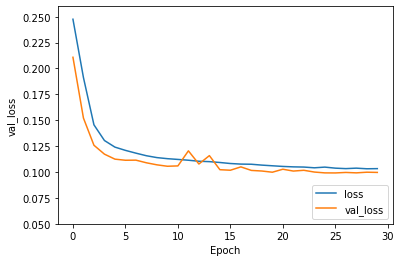

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('val_loss')
plt.ylim([0.05, 0.26])
plt.legend(loc='lower right')

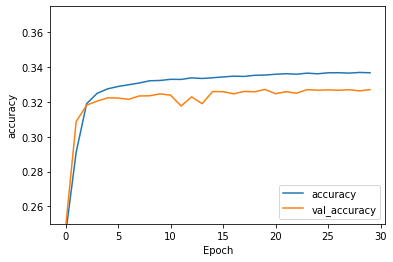

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.ylim([0.25, 0.375])
plt.legend(loc='lower right')

# Evaluation (facultative)

Petit module d'évaluation du model, ne sert pas à grand chose dans le cadre
de ce projet mais permet d'avoir une idée de la moyenne d'efficacité de notre réseau à la fin du training.
Cela montre également qu'il est possible d'enregistrer le model puis après le réupérer, ce qui permet d'éviter de refaire le training à chaque fois qu'on veut faire une prédiction sur de nouvelles valeurs aléatoires.

In [ ]:
from keras import models 
from keras.models import load_model
reconstructed_model = load_model("my_model")


# First, let's create a training Dataset instance.
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Now we get a test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
test_dataset = test_dataset.batch(64)

print("Evaluate")
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

print("Evaluate_save")
result = reconstructed_model.evaluate(test_dataset)
dict(zip(reconstructed_model.metrics_names, result))

Evaluate
5196/5196 [==============================] - 25s 5ms/step - loss: 0.0967 - accuracy: 0.3364 - mae: 0.0967
Evaluate_save
5196/5196 [==============================] - 22s 4ms/step - loss: 0.0967 - accuracy: 0.3364 - mae: 0.0967


{'accuracy': 0.3364470899105072,
 'loss': 0.09673544764518738,
 'mae': 0.09673544764518738}

# Prédiction et génération du .txt



In [ ]:
def position_predict(description, is_test):
    if is_test :
      input = description
    else :
      input = json_to_numpy(description)

    # Ici condition booléenne nécessaire car pour X_To_Train on a déjà fait le json_to_numpy
    input = np.expand_dims(input, axis=0)
    prediction = model.predict(input) 
    return prediction[0] 

# 1 - prediction = %de win des blancs vu que l'algo sort la proba de win des noirs.
# P(noirs) + P(blancs) = 1


print("Prediction this sample:")

print("La matrice résultat est de dimension")
print(X_to_predict[13].shape)
print()
print("Plan 0 du tenseur : contient les pieces contenant une pierre noire sur l'exemple 10")
print(X_to_predict[13][:,:,0])
print()
print("Plan 1 du tenseur : contient les pieces contenant une pierre blanche sur l'exemple 10")
print(X_to_predict[13][:,:,1])

prediction = position_predict(X_to_predict[13], True)

print()

print("You predicted")
print("Black : ", prediction)
print("White : ", 1-prediction)

print()

def create_result_file(newdata):
    ''' Exemple de méthode permettant de générer le fichier de resultats demandés. '''
    resultat  = [position_predict(d, True) for d in X_to_predict]
    with open("my_predictions.txt", "w") as f:
         for p in resultat:
            f.write(str(p)+"\n")

print("Ecriture dans le fichier my_predictions.txt en cours... ")
create_result_file(X_to_predict)
print("Génération du fichier résultat finie !")

Prediction this sample:
La matrice résultat est de dimension
(9, 9, 2)

Plan 0 du tenseur : contient les pieces contenant une pierre noire sur l'exemple 10
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Plan 1 du tenseur : contient les pieces contenant une pierre blanche sur l'exemple 10
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

You predicted
Black :  [0.593571]
White :  [0.406429]

Ecriture dans le fichier my_predictions.txt en cours... 
Génération du fichier résultat finie !


# **Condensé de toutes les étapes en utilisant le model enregistré**

Attention ici on génère un fichier **my_predictions_2.txt** en utilisant une sauvegarde de notre model, cela permet d'éviter d'avoir à refaire toutes les étapes de training.

On écrase pas **my_predictions.txt** initial.

Ce bloc de code est indépendant des précédents vu qu'on refait tous les imports / conversions / fonctions utiles.

On génère aléatoirement 1000 nouveau boards issus de data_to_evaluate.


In [ ]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D,  MaxPooling2D, BatchNormalization
import tensorflow.keras.optimizers as optimizers
import tensorflow as tf

from keras import models 
from keras.models import load_model

############################ Import du fichier d'exemples ############################

def get_data(file):
    ''' Returns the set of samples from the local file or download it if it does not exists'''
    import gzip, os.path
    import json

    if not os.path.isfile(file):
        print("File", file, "not found, I am downloading it...", end="")
        import urllib.request 
        urllib.request.urlretrieve ("https://www.labri.fr/perso/lsimon/IA-M1/" + file, file)
        print(" Done")

    with gzip.open(file) as fz:
        data = json.loads(fz.read().decode("utf-8"))
    return data

data = get_data("samples-9x9.json.gz")
data_to_evaluate = get_data("positions-to-evaluate-9x9.json.gz")


############################ CONVERTISSEUR VERS NUMPY ############################
import numpy as np

def name_coord(s):
    assert s != "PASS"
    indexLetters = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'J':8}

    col = indexLetters[s[0]]
    lin = int(s[1:]) - 1
    return col, lin

 # Vous pouvez utiliser votre propre fonction ici si vous voulez utiliser un autre encodage
def json_numpy(sample):
  to_return = np.zeros((9,9,2))
  indices = ["black_stones", "white_stones"]
  for plane, name in enumerate(indices):
    for coord_name in sample[name]:
      x, y = name_coord(coord_name)
      to_return[x,y,plane] = 1
  return to_return

############################ Génération des 1000 exemples à prédire ############################

X_2_predict = []
for d in data_to_evaluate:
  X_2_predict.append(json_numpy(d))
X_2_predict = np.array(X_2_predict)

print("Et voici les 1000 exemples à prédire")
print(X_2_predict.shape)

############################ PREDICTION ############################

model_2 = load_model("my_model")  #Chargement du model enregistré précédemment

def pos_predict(description, is_test):
    if is_test :
      input = description
    else :
      input = json_numpy(description)
    input = np.expand_dims(input, axis=0)
    prediction = model_2.predict(input)
    return prediction[0]

    # 1 - prediction = %de win des blancs vu que l'algo sort la proba de win des noirs :
    # P(noirs) + P(blancs) = 1

def create_res_file(newdata):
    resultat  = [pos_predict(d, True) for d in X_2_predict]
    with open("my_predictions_2.txt", "w") as f:
         for p in resultat:
            f.write(str(p)+"\n")

print("Ecriture dans le fichier my_predictions_2.txt en cours... ")
create_res_file(X_2_predict)
print("Génération du fichier résultat finie !")

Et voici les 1000 exemples à prédire
(1000, 9, 9, 2)
Ecriture dans le fichier my_predictions_2.txt en cours... 
Génération du fichier résultat finie !


# Terminal nécessaire pour générer le .html

Commande **jupyter nbconvert --to html notebook.ipynb**
à exécuter, nécessite en amont de télécharger le **notebook.ipynb** après exécution du code, et le mettre dans **/content**.


In [ ]:
from IPython.display import JSON
from google.colab import output
from subprocess import getoutput
import os

def shell(command):
  if command.startswith('cd'):
    path = command.strip().split(maxsplit=1)[1]
    os.chdir(path)
    return JSON([''])
  return JSON([getoutput(command)])
output.register_callback('shell', shell)

In [ ]:
#@title Colab Shell
%%html
<div id=term_demo></div>
<script src="https://code.jquery.com/jquery-latest.js"></script>
<script src="https://cdn.jsdelivr.net/npm/jquery.terminal/js/jquery.terminal.min.js"></script>
<link href="https://cdn.jsdelivr.net/npm/jquery.terminal/css/jquery.terminal.min.css" rel="stylesheet"/>
<script>
  $('#term_demo').terminal(async function(command) {
      if (command !== '') {
          try {
              let res = await google.colab.kernel.invokeFunction('shell', [command])
              let out = res.data['application/json'][0]
              this.echo(new String(out))
          } catch(e) {
              this.error(new String(e));
          }
      } else {
          this.echo('');
      }
  }, {
      greetings: 'Welcome to Colab Shell',
      name: 'colab_demo',
      height: 250,
      prompt: 'colab > '
  });